# Predicting Mammographic Mass Malignancies
### Casey Thayer

Breast cancer is typically detected by a mammography that identifies a mass and based on a variety of attributes, the severity of the cancer can be determined. Utlizing a dataset detailing the features of mammographic masses from a number of patients from Wisconsin, I employed Logistic Regression and Random Forest Classifer models to predict whether the mass was benign or malignant.


## Dataset information
Mammographic Masses dataset: http://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data
Mammographic Masses dataset description: http://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.names

#### Size and structure of the dataset:
The Mammographic Masses dataset contains 6 features (BI-RADS, Age, Shape, Margin, Density, Severity) and 960 attributes. 

Most of these features are numerical columns but many can be decoded into categorical variables based on the dataset description that accompanies the dataset at the url above.

## Overview
In this project, I clean the mammographic masses dataset through imputation or removal of missing values, decoding numerical values into categorical variables, consolidationg of categorical variables, one-hot encoding categorical variables into columns with binary values, and z-normalization of numerical variables.

The distributions of the features in the cleaned dataset are evaluated with either a histogram for numerical values or a bar chart for categorical values. K-Means Clustering is performed to group together masses with similar attributes based on a number of features in the dataset. The cluster label is added to the dataset.

A Logistic Regression model and a Random Forest Classifier model are used to predict whether a mammographic mass is benign or malignant. These two models are trained and tested with multiple features from the dataset and the Severity column as the expert label. 

The accuracy of each model is evaluated through calculating accuracy 
measures such as accuracy rate, precision, and recall. Furthermore, an ROC plot is generated for each model with a linear line included for reference. The AUC score is included on each plot to describe how well the Logistic Regression Model and the Random Forest Classifier Models are performing.

In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
import matplotlib.pyplot as plt
import matplotlib


## Define functions to clean dataset

Below, I define the functions required to clean the dataset. These functions primarily take the data frame and a column name as an argument. The Replace function was created due a few potential typos in the BI-RAD column where there were scores greater than 6, however, the scoring rubric does not exceed 6. 


In [2]:
# Define a function to coerce a column to numeric and impute missing values with the median
# The Impute function takes a data frame and the name of a column in the data frame
def Impute(x, ColumnName):
    x.loc[:, ColumnName] = pd.to_numeric(x.loc[:, ColumnName], errors = 'coerce') # convert all values to numeric or NaN
    HasNan = np.isnan(x.loc[:, ColumnName])
    x.loc[HasNan, ColumnName] = np.nanmedian(x.loc[:, ColumnName]) # replace all NaNs with the median of the column

# Define a function to replace outliers in a numeric column with an upper limit
# The Replace functon takes a data frame, a column from the data frame, and the upper limit of the column
def Replace(x, ColumnName, UpperValue):
    TooHigh = x.loc[:, ColumnName] > UpperValue # identify values higher than the upper limit
    x.loc[TooHigh, ColumnName] = UpperValue # replace values that are too high with the upper limit
    
# Define a function to Z-Normalize numeric values in a column
# The ZNorm function takes a data frame and a numerical column from the data frame
def ZNorm(x, ColumnName):
    d = x.loc[:, ColumnName]
    normd = (d - np.mean(d))/np.std(d) # perform z-normalization
    x.loc[:, ColumnName] = normd # replace original column with the z-normalized data
    
# Define a function to decode numeric values into categorical names
# The Decode function takes a data frame, a column from the data frame, a value from the column, and the name to replace the value in the column
def Decode(x, ColumnName, Value, Name):
    Replace = x.loc[:, ColumnName] == Value # identify the value to be decoded
    x.loc[Replace, ColumnName] = Name # decode the value with the given categorical name

# Define a function to consolidate categorical variables in a given column
# The Consolidate function takes a data frame, a column name from the data frame, a name from the current column, and the consolidated name to replace the current name
def Consolidate(x, ColumnName, Name, ConsolName):
    x.loc[x.loc[:, ColumnName] == Name, ColumnName] = ConsolName # consolidate a categorical variable into another categorical variable within a given column
    
# Define a function to one-hot encode categorical data
# The OneHotEncode function takes a data frame, a new column to create with binary values, the column name to one-hot encode, and the categorical variable name to set the binary values within the new column
def OneHotEncode(x, NewCol, ColumnName, Name):
    x.loc[:, NewCol] = (x.loc[:, ColumnName] == Name).astype(int) # create a new column to hold the binary values based on the categorical variables within the given column
    

# Define functions for modeling

The following functions were created to fit the Logistic Regression model and Random Forest Classifer model to the trained dataset. The trained dataset is obtained using the SplitDataset function and 30% of the data are reserved for testing. 

In [3]:
# Define a function to split the dataset into testing and training datasets
# The SplitDataset function takes a data frame as an argument
# The SplitDataset function returns a test data frame and a training data frame
def SplitDataset(x):
    r = 0.3 # fraction of dataset that will become test data
    N = len(x)
    isTest = np.random.rand(N) < r # randomly select 30% of the data frame
    Test = x.loc[isTest, :].copy()
    Train = x.loc[~isTest, :]. copy() # use boolean indexing to split dataset into testing and training subsets
    return(Test, Train)

# Define a function to train and test the logistic regression model
# The LogRegModel function takes the training and target features from the training dataset and the testing features from the test dataset
# The LogRegModel function returns a prediction based on the inputs
def LogRegModel(TrainFeatures, TrainTargets, TestFeatures):
    clf = LogisticRegression() # instantiate logistic regression model
    clf.fit(TrainFeatures, TrainTargets) # fit the model to the training dataset
    prediction = clf.predict(TestFeatures) # make a prediction of the test data using the model trained on the training dataset
    return prediction # return predicted values

# Define a function to train and test the random forest classifier model
# The RandForest function takes the features and target from the training dataset and the test features from the test dataset
# The RandForest function returns a prediction based on the inputs
def RandForest(TrainFeatures, TrainTargets, TestFeatures):
    estimators = 10 # number of trees parameter
    mss = 2 # minimum samples split parameter
    clf = RandomForestClassifier(n_estimators = estimators, min_samples_split = mss)
    clf.fit(TrainFeatures, TrainTargets) # fit model to training dataset
    prediction = clf.predict(TestFeatures) # make a prediction of the test data using the model trained on the training dataset
    return prediction # return predicted values



# Define functions for preparing model evaluation

The following functions are created to calculate the probabilities of predicting the expert label/target of the test dataset correctly. A function to create a confusion matrix is also generated to prepare the model for further evaluation.

In [4]:
# Define a funciton to calculate the probabilities of predicting the target from the test dataset
# The getLogRegProbs function takes the features and target from the training dataset and the test features from the test dataset
# The getLogRegProbs function returns the probability of predicting the target as 1 in the test dataset with the Logistic Regression model
def getLogRegProbs(TrainFeatures, TrainTargets, TestFeatures):
    clf = LogisticRegression() # instantiate Logistic Regression model
    clf.fit(TrainFeatures, TrainTargets) # fit the Logistic Regression model to the features and target from the training dataset
    BothProbabilities = clf.predict_proba(TestFeatures) # calculate the the probabilites of predicting the test target outcome to be 0 or 1
    probabilities = BothProbabilities[:,1] # the second column holds the probabilites of the test target being an outcome of 1
    return probabilities

# Define a function to calculate the probabilities of predicting the target from the test dataset 
# The getRandForestProbs function takes the features and target from the training dataset and the features from the test dataset
# The getRandForestProbs function returns the probability of predicting the target as 1 in the test dataset with the Random Forest Classifier model
def getRandForestProbs(TrainFeatures, TrainTargets, TestFeatures):
    clf = RandomForestClassifier() # instantiate Random Forest Classifier model
    clf.fit(TrainFeatures, TrainTargets) # fit the Random Forest Classifier model to the features and target of the training dataset
    BothProbabilities = clf.predict_proba(TestFeatures) # calculate the probabilities of predicting the test target outcome to be a 0 or a 1
    probabilities = BothProbabilities[:,1] # the second column holds the probabilities of the test target being an outcome of 1
    return probabilities

# Define a function to create a confusion matrix based on the target from the test dataset, predictions, and threshold
# The createCM function takes the targets from the test dataset, the predictions, and the threshold to create a confusion matrix
# The createCM function returns the number of true negatives, false positives, false negatives, and true positives
def createCM(TestTargets, Predictions, Threshold):
    CM = confusion_matrix(TestTargets, Predictions) # create confusion matrix based on the target from the test dataset and the predictions
    tn, fp, fn, tp = CM.ravel() # create variables to hold the values of the true negatives, false positives, false negatives, and true positives
    return tn, fp, fn, tp


# Define functions for model evaluation

The following functions calculate the metrics to evaluate the performance of the models and plot ROC curves.

In [5]:
# Define a function to calculate the accuracy measures using the target from the test dataset and the predicted values
# The AccuracyMeasures function takes the targets from the test dataset, and the predictions
# The AccuracyMeasures function returns the accuracy rate, precision, and recall values
def AccuracyMeasures(TestTargets, Predictions):
    ACC = accuracy_score(TestTargets, Predictions) # calculate the accuracy rate based on the targets from the test dataset and the predictions
    PRE = precision_score(TestTargets, Predictions) # calculate the precision value based on the target from the test dataset and the predictions
    REC = recall_score(TestTargets, Predictions) # calculate the recall value based on the target from the test dataset and the predictions
    return ACC, PRE, REC

# Define a function to calculate the false positive rate, true positive rate, threshold, and area under the curve
# The calcROC function takes the target from the test dataset and the probabilities of predicting the values in the test dataset based on the model employed
# the calcROC function returns the false positive rate, true positive rate, threshold, and the area under the curve (AUC)
def calcROC(TestTargets, Probabilities):
    fpr, tpr, th = roc_curve(TestTargets, Probabilities) # calculate the false positive rate, true positive rate, and threshold
    AUC = auc(fpr, tpr) # calculate the area under the curve (AUC) based on the false positive rate and the true positive rate
    return fpr, tpr, th, AUC

# Define a function to create an ROC plot for the Logistic Regression model
# The plotLogRegROC function takes the false positive rate, true positive rate, and the area under the curve (AUC) calculated by the Logistic Regression model
# The plotLogRegROC function returns a plot of the ROC curve with a linear line plotted for reference, the ROC score is presented in the corner of the plot
def plotLogRegROC(fpr, tpr, AUC):
    plt.rcParams["figure.figsize"] = [8, 8] # square plot area
    font = {'family' : 'normal', 'weight' : 'bold', 'size' : 18} # set the font specifications
    matplotlib.rc('font', **font)
    plt.figure()
    plt.title('ROC Curve for Logistic Regression Model') # set the title of the plot
    plt.xlabel('FPR') # label the x axis
    plt.ylabel('TPR') # label the y axis
    plt.plot(fpr, tpr, LW=3, label='ROC curve (AUC = %0.2f)' % AUC) # include the ROC score in the legend
    plt.plot([0, 1], [0, 1], color='navy', LW=3, linestyle='--') # reference line for random classifier
    plt.legend(loc="lower right") # plot the legend in the lower right part of the plot
    plt.show() 
    
# Define a function to create an ROC plot for the Random Forest Classifier model
# The plotLogRegROC function takes the false positive rate, true positive rate, and the area under the curve (AUC) calculated by the Random Forest Classifier model
# The plotLogRegROC function returns a plot of the ROC curve with a linear line plotted for reference, the ROC score is presented in the corner of the plot
def plotRandForestROC(fpr, tpr, AUC):
    plt.rcParams["figure.figsize"] = [8, 8] # square plot area
    font = {'family' : 'normal', 'weight' : 'bold', 'size' : 18} # set the font specifications
    matplotlib.rc('font', **font)
    plt.figure()
    plt.title('ROC Curve for Random Forest Classifier Model') # set the title of the plot
    plt.xlabel('FPR') # label the x axis
    plt.ylabel('TPR') # label the y axis
    plt.plot(fpr, tpr, LW=3, label='ROC curve (AUC = %0.2f)' % AUC) # include the ROC score in the legend
    plt.plot([0, 1], [0, 1], color='navy', LW=3, linestyle='--') # reference line for random classifier
    plt.legend(loc="lower right") # plot the legend in the lower right part of the plot
    plt.show() 

# Load and clean dataset

The dataset is loaded and the columns are named appropriately based on the dataset description. I printed the shape of the dataset and the datatypes of each feature to get an idea of how the data are structured. 

The missing values from the BI-RADS, Age, and Density columns were imputed with the median of each column. The BI-RADS column describes a ranking from 0-6. All outliers that were above 6, were replaced with the upper limit of 6.

The Age and BI-RADS columns were Z-Normalized.

The Shape, Margin, and Density columns were decoded from numerical values to categorical variables. 

The categorical variables, round and lobular, in the Shape column were consolidated to oval. The categorical variable, obscured, in the Margin column was consolidated to ill-defined. 

In [6]:
# Read in dataset
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data"
Mamm = pd.read_csv(url, header=None)


In [7]:
# Name the columns of the dataset
Mamm.columns = ["BI-RADS", "Age", "Shape", "Margin", "Density", "Severity"]

# Get the number of observations and attributes of the Mamm dataset
print('The shape of the dataset is: ', Mamm.shape)

# Get the datatypes of each feature in the Mamm dataset
Mamm.dtypes

The shape of the dataset is:  (961, 6)


BI-RADS     object
Age         object
Shape       object
Margin      object
Density     object
Severity     int64
dtype: object

In [8]:
# Call the Impute function to impute missing values in the BI-RADS, Age, and Density columns
Impute(Mamm, "BI-RADS")
Impute(Mamm, "Age")
Impute(Mamm, "Density")

# The BI-RADS column only is defined for only values 0-6
# Call the Replace function to remove any outlier values that are greater than the upper limit of 6
Replace(Mamm, "BI-RADS", 6)

# Call the ZNorm function to normalize the numeric values in the Age and BI-RADS column
ZNorm(Mamm, "Age")
ZNorm(Mamm, "BI-RADS")

# Call the Decode function to convert the numerical values in the Shape column to categorical variables
# Impute missing values with the most common categorical variable
Decode(Mamm, "Shape", "1", "round")
Decode(Mamm, "Shape", "2", "oval")
Decode(Mamm, "Shape", "3", "lobular")
Decode(Mamm, "Shape", "4", "irregular")
Decode(Mamm, "Shape", "?", "irregluar")

# Call the Decode function to convert the numerical values in the Margin column to categorical variables
# Impute missing values with the most common categorical variable
Decode(Mamm, "Margin", "1", "circumscribed")
Decode(Mamm, "Margin", "2", "microlobulated")
Decode(Mamm, "Margin", "3", "obscured")
Decode(Mamm, "Margin", "4", "ill-defined")
Decode(Mamm, "Margin", "5", "spinculated")
Decode(Mamm, "Margin", "?", "circumscribed")

# Call the Decode function to convert the numerical values in the Density column to categorical variables
Decode(Mamm, "Density", 1, "High")
Decode(Mamm, "Density", 2, "Iso")
Decode(Mamm, "Density", 3, "Low")
Decode(Mamm, "Density", 4, "Fat-Containing")

# Call the Consolidate function to simplify categorical variables
Consolidate(Mamm, "Shape", "round", "oval")
Consolidate(Mamm, "Shape", "lobular", "oval")
Consolidate(Mamm, "Margin", "obscured", "ill-defined")

# Examine the distribution of features

The numerical variables (BI-RADS, Age, and Severity) are plotted as histograms to show the distribution. The BI-RADS column and the Age column have both been Z-Normalized.

The Age data appear to be normally distributed and the Severity column shows that there are a similar number of benign and malignant masses. 

The categorical variables (Shape, Margin, and Density) are plotted as bar charts.

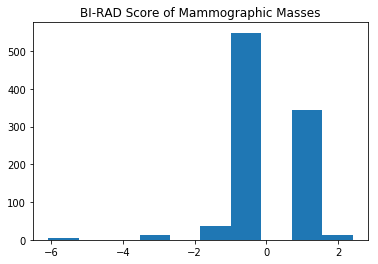

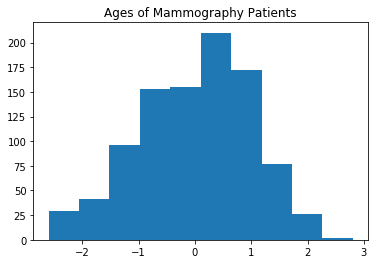

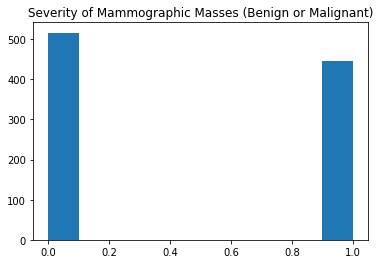

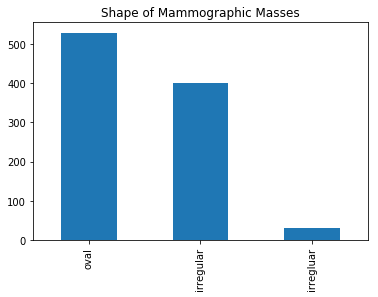

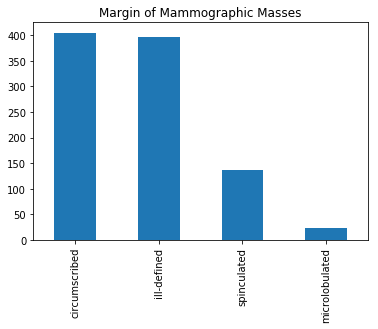

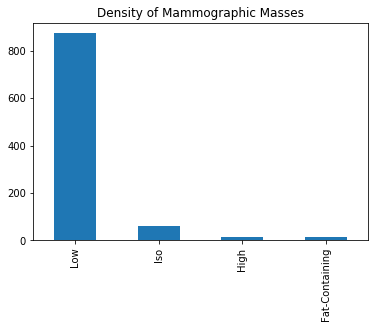

In [9]:
# Display the distribution of numerical variables
# Plot histogram of BI-RADS column (values have been Z-Normalized)
# BI-RADS column represents a score based on a radiology image to describe the severity of a mammographic mass
plt.hist(Mamm.loc[:, "BI-RADS"])
plt.title('BI-RAD Score of Mammographic Masses')
plt.show()

# Plot histogram of Age column (values have been Z-Normalized)
# The Age column represents the age of each patient associated with the mammographic mass in the table
plt.hist(Mamm.loc[:, "Age"])
plt.title('Ages of Mammography Patients')
plt.show()

# Plot histogram of Severity column
# The Severity column is a binary column that denotes whether the mammographic mass is benign or malignant
plt.hist(Mamm.loc[:, "Severity"])
plt.title('Severity of Mammographic Masses (Benign or Malignant)')
plt.show()

# Display the distribution of categorical variables
# Plot the Shape column of the Mamm dataset
# The Shape column was a numerical column that was decoded to categorical variables to describe the shape of each mammographic mass
Mamm.loc[:, "Shape"].value_counts().plot(title = 'Shape of Mammographic Masses', kind = 'bar')
plt.show()

# Plot the Margin column of the Mamm dataset
# The Margin column was a numerical column that was decoded to categorical variables to describe the margin of each mammographic mass
Mamm.loc[:, "Margin"].value_counts().plot(title = 'Margin of Mammographic Masses', kind = 'bar')
plt.show()

# Plot the Density column of the Mamm dataset
# The Density column was a numerical column that was decoded to cateogorical variables to describe the density of each mammographic mass
Mamm.loc[:, "Density"].value_counts().plot(title = 'Density of Mammographic Masses', kind = 'bar')
plt.show()

# K-Means Clustering

To prepare the data for K-Means Clustering, the Margin column was one-hot encoded to three new columns (IsCirc, IsMicroLob, IsSpincu) made up of binary elements. The ill-defined data can be inferred by the binary results of the other three columns. 

These columns were then Z-Normalized and he Margin column is now obsolete and was removed from the dataset.

The age, radiology score (BI-RADS) and one-hot encoded margin columns have been used to cluster the characteristics of the masses using the K-Means clustering method. The cluster labels have been added to the original, cleaned mammographic masses dataset.

In [10]:
# Call the OneHotEncode function to create three new columns with binary values
OneHotEncode(Mamm, "IsCirc", "Margin", "circumscribed")
OneHotEncode(Mamm, "IsMicroLob", "Margin", "microlobulated")
OneHotEncode(Mamm, "IsSpincu", "Margin", "spinculated")

# Z-Normalize the following columns that have been one-hot encoded
ZNorm(Mamm, "IsCirc")
ZNorm(Mamm, "IsMicroLob")
ZNorm(Mamm, "IsSpincu")

# Remove obsolete column
Mamm = Mamm.drop("Margin", axis=1)


In [11]:
# Create a subset of the Mamm dataset to perform k-means clustering
MammSubset = pd.DataFrame()

# Add a numerical attribute and the one-hot encoded categorical attributes to the subset
MammSubset.loc[:, 0] = Mamm.loc[:, "Age"]
MammSubset.loc[:, 1] = Mamm.loc[:, "IsCirc"]
MammSubset.loc[:, 2] = Mamm.loc[:, "IsMicroLob"]
MammSubset.loc[:, 3] = Mamm.loc[:, "IsSpincu"]
MammSubset.loc[:, 4] = Mamm.loc[:, "BI-RADS"]


# Generate random cluster centroid guesses as a dataframe
ClusterCentroidGuesses = pd.DataFrame()
ClusterCentroidGuesses.loc[:,0] = [-1, 1, 0]
ClusterCentroidGuesses.loc[:,1] = [2, 1, 0]
ClusterCentroidGuesses.loc[:,2] = [-2, 0, 1]
ClusterCentroidGuesses.loc[:,3] = [1, 1, 1]
ClusterCentroidGuesses.loc[:,4] = [1, -1, 1]

# Perform K-Means Clustering on the age and margin columns of the subset of the Mamm dataset
kmeans = KMeans(n_clusters=3, init=ClusterCentroidGuesses, n_init=1).fit(MammSubset)
Labels = kmeans.labels_
ClusterCentroids = pd.DataFrame(kmeans.cluster_centers_)


# Model data to predict malignancies with Logistic Regression and Random Forest Classifier modeling

The Mammographic Masses dataset was split into testing and training datasets.

A Logistic Regression model and a Random Forest Classifier model were employed to predict whether a patient's mammographic mass is benign or malignant.

Binary-Choice Question: Does the patient have a benign or malignant mammographic mass?

The expert label when training and testing both models was the Severity column. This column denotes whether a mass is benign or malignant.

The features that were used as inputs to both models were the following:
    Age
    Margin (one-hot encoded into IsCirc, IsMicroLob, and IsSpincu)
    BI-RADS (a radiology score 0-6, 6 being of the highest risk)
    
From a high-level perspective, these two predictive models (Logistic Regression and Random Forest Classifier) aim to predict whether a mammographic mass is benign or malignant based on the age, the margin morphologies and the radiological scores associated with each mass.

In [15]:
# Call a function to split the Mamm dataset into separate testing and training datasets
MammTest, MammTrain = SplitDataset(Mamm)

# Define the training features for the training dataset
# The training features are the age of the patient and the margin morphologies of the mammographic masses
MammTrainFeatures = pd.DataFrame()
MammTrainFeatures.loc[:, 0] = MammTrain.loc[:, "Age"]
MammTrainFeatures.loc[:, 1] = MammTrain.loc[:, "IsCirc"]
MammTrainFeatures.loc[:, 2] = MammTrain.loc[:, "IsMicroLob"]
MammTrainFeatures.loc[:, 3] = MammTrain.loc[:, "IsSpincu"]
MammTrainFeatures.loc[:, 4] = MammTrain.loc[:, "BI-RADS"]


# Define the target features for the training dataset
# The expert label is the severity associated with the mammographic masses
MammTrainTargets = MammTrain.loc[:, "Severity"]

# Define the test features for the test dataset
# The test features are the age of the patient and the margin morphologies of the mammograpic masses
MammTestFeatures = pd.DataFrame()
MammTestFeatures.loc[:, 0] = MammTest.loc[:, "Age"]
MammTestFeatures.loc[:, 1] = MammTest.loc[:, "IsCirc"]
MammTestFeatures.loc[:, 2] = MammTest.loc[:, "IsMicroLob"]
MammTestFeatures.loc[:, 3] = MammTest.loc[:, "IsSpincu"]
MammTestFeatures.loc[:, 4] = MammTest.loc[:, "BI-RADS"]


# Define the target feature for the test dataset
# The expert label is the severity associated with the mammographic masses
MammTestActual = MammTest.loc[:, "Severity"]

#### Logistic Regression Model
# Call function to obtain a prediction from the tested the trained logistical regression model for the Mamm dataset
MammLogRegPrediction = LogRegModel(MammTrainFeatures, MammTrainTargets, MammTestFeatures)

#### Random Forest Classifier Model
# Call function to obtain a prediction from the tested and trained random forest model
MammRandForestPrediction = RandForest(MammTrainFeatures, MammTrainTargets, MammTestFeatures)


/Users/caseythayer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# Evaluate the Logistic Regression and Random Forest Classifier models

Accuracy Measure Testing / ROC curve:
    
For both the Logistic Regression Model and the Random Forest Classifier Models, confusion matrices were created, accuracy measures were calculated, and ROC plots were generated as follows:
    
The probabilities of predicting a test target (Severity) were calculated and predictions were made based on a threshold of 0.5 and the results from either the Logistic Regression or Random Forest Classifier model. Confusion matrices were made based on these predictions and the threshold of 0.5 to calculate the true 
negatives, false positives, false negatives, and false positives associated with the test dataset for both models. Accuracy measures, such as accuracy, precision, and recall were calculated to describe how well the predictions from the Logistic Regression and the Random Forest Classifier models matched the test targets.

Although the results change as the script is re-run based on the randomization of the training and testing datasets, the Accuracy Measures calculated are typically around the following values:
    
    LOGISTIC REGRESSION MODEL
    Accuracy = 0.8
    Precision = 0.8
    Recall = 0.8

    RANDOM FOREST CLASSIFIER MODEL
    Accuracy = 
    Precision =
    Recall =


The ROC curves for both the Logistic Regression and the Random Forest Classifier models were generated by first calculating the true positive rate, the false positive rate, threshold, and AUC for many confusion matrices. These data have been plotted on a curve with a linear reference line for comparison. Both ROC curves appear to have a good shape with an AUC scores around 0.85, which makes us more confident in the performance of both the Logistic Regression and Random Forest Classifer models in predicting breast cancer from this particular dataset.

/Users/caseythayer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/caseythayer/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))



 Logistic Regression Accuracy Measures:

 Accuracy Rate =  0.82

 Precision =  0.78

 Recall =  0.86


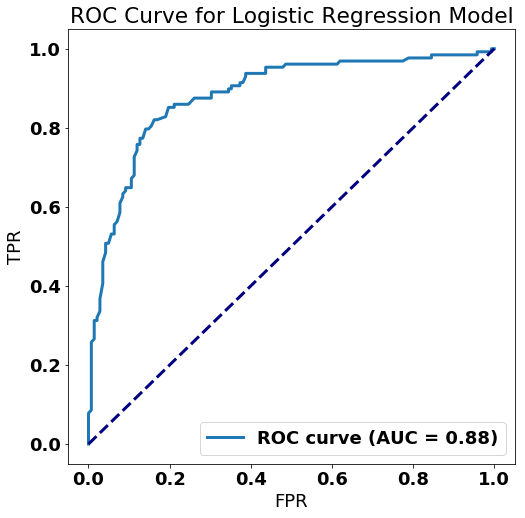

/Users/caseythayer/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



 Random Forest Classifier Accuracy Measures:

 Accuracy Rate =  0.81

 Precision =  0.8

 Recall =  0.81


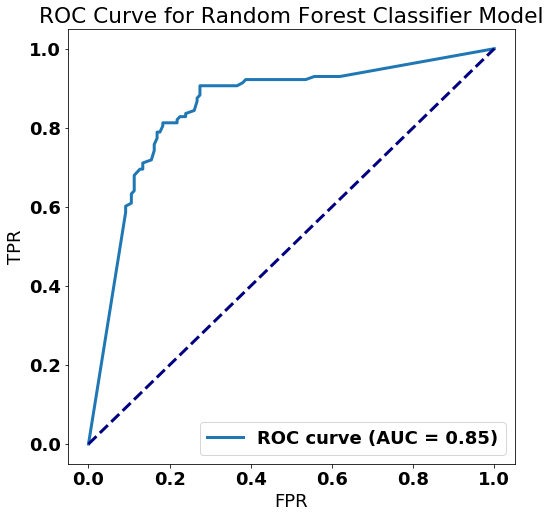

In [16]:
#### Evaluate Logistic Regression and Random Forest Classifier Models through Accuracy Measures and ROC Plot
# Define the probability threshold to evaluate both Logistic Regression and Random Forest Classifier Models
MammThreshold = 0.5

## Logistic Regression Model Accuracy and ROC plot
# Get the probability of predicting the targets with the logistic regression model from the Mamm test dataset
MammLogRegProbs = getLogRegProbs(MammTrainFeatures, MammTrainTargets, MammTestFeatures)

# Define the predictions of the target from the Mamm dataset based on the threshold and calculated probabilities from the logistic regression model
MammLogRegPredict = (MammLogRegProbs > MammThreshold).astype(int)

# Create a confusion matrix and define the true negative, false positive, false negative, and true positive values based on the logistic regression model
LR_TrueNeg, LR_FalsePos, LR_FalseNeg, LR_TruePos = createCM(MammTestActual, MammLogRegPredict, MammThreshold)

# Calculate the accuracy, precision, and recall associated with the targets from the Mamm test dataset and the predicted values from the logistic regression model
LR_Accuracy, LR_Precision, LR_Recall = AccuracyMeasures(MammTestActual, MammLogRegPredict)

# Print accuracy measures for the Logistic Regression
print("\n Logistic Regression Accuracy Measures:")
print("\n Accuracy Rate = ", np.round(LR_Accuracy, 2))
print("\n Precision = ", np.round(LR_Precision, 2))
print("\n Recall = ", np.round(LR_Recall, 2))

# Calculate the false positive rate, true positive rate, threshold, and area under the curve based on the logistic regression model
LR_MammFPR, LR_MammTPR, LR_MammTH, LR_MammAUC = calcROC(MammTestActual, MammLogRegProbs)

# Plot an ROC curve to evaluate the performance of the logistic regression model used to predict if a patient has a benign or malignant mammographic mass
plotLogRegROC(LR_MammFPR, LR_MammTPR, LR_MammAUC)

## Random Forest Model Accuracy and ROC plot
# Get the probability of predicting the targets with the random forest classifier model from the Mamm test dataset
MammRandForestProbs = getRandForestProbs(MammTrainFeatures, MammTrainTargets, MammTestFeatures)

# Define the predictions of the target from the Mamm dataset based on the threshold and calculated probabilities from the random forest classifer model
MammRandForestPredict = (MammRandForestProbs > MammThreshold).astype(int)

# Create a confusion matrix and define the true negative, false positive, false negative, and true positive values based on the random forest classifier model
RF_TrueNeg, RF_FalsePos, RF_FalseNeg, RF_TruePos = createCM(MammTestActual, MammRandForestPredict, MammThreshold)

# Calculate the accuracy, precision, and recall associated with the targets from the Mamm test dataset and the predicted values from the random forest classifier model
RF_Accuracy, RF_Precision, RF_Recall = AccuracyMeasures(MammTestActual, MammRandForestPredict)

# Print accuracy measures for the Random Forest Classifier Model 
print("\n Random Forest Classifier Accuracy Measures:")
print("\n Accuracy Rate = ", np.round(RF_Accuracy, 2))
print("\n Precision = ", np.round(RF_Precision, 2))
print("\n Recall = ", np.round(RF_Recall, 2))

# Calculate the false positive rate, true positive rate, threshold, and area under the curve based on the random forest classifer model
RF_MammFPR, RF_MammTPR, RF_MammTH, RF_MammAUC = calcROC(MammTestActual, MammRandForestProbs)

# Plot an ROC curve to evalute the performance of the random forest model used to predict if a patient has a benign or malignant mammographic mass
plotRandForestROC(RF_MammFPR, RF_MammTPR, RF_MammAUC)

# Conclusions

The mammographic masses dataset was cleaned to utlize unsupervised and supervised learning techniques to understand how the attributes of a mass can be used to predict whether it is benign or malignant. K-Means Clustering grouped similar masses together and are plotted to visually observe how the different mammographic masses are related to each other based on the attributes within the dataset. 

Both supervised learning models, Logistic Regression and Random Forest Classifer, exhibited good performance (AUC of each model exceeds 0.8) when predicting whether a mammographic mass was benign or malignant. Leveraging image classification and including more detailed attributes around the mammographic masses could enhance the predictions and provide a more robust model for determining the severity of a mass in the future.